In [4]:
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

In [5]:
BATCH_SIZE = 4
EPOCHS = 20
IMAGE_SIZE = 256
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
image_size = 0
data_dir = r"C:\Users\DELL\miniproject\plantdiseasedetection\PlantVillage"
CHANNELS=3
AUTOTUNE = tf.data.AUTOTUNE

In [6]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = ds.cardinality().numpy()
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=default_image_size,
  batch_size=BATCH_SIZE
)
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

Found 9127 files belonging to 8 classes.


In [8]:
class_names=dataset.class_names
n_classes=len(class_names)
print(class_names, n_classes)

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy'] 8


In [9]:
for image_batch, labels_batch in train_ds:
              print(image_batch.shape)
              print(labels_batch.shape)
              break

(4, 256, 256, 3)
(4,)


In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [11]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [12]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  
])

In [13]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1

In [14]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=batch_input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (4, 256, 256, 3)          0         
                                                                 
 sequential_1 (Sequential)   (4, 256, 256, 3)          0         
                                                                 
 conv2d (Conv2D)             (4, 254, 254, 32)         896       
                                                                 
 max_pooling2d (MaxPooling2D  (4, 127, 127, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (4, 125, 125, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (4, 62, 62, 64)          0         
 2D)                                                  

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the callback function
checkpoint_callback = ModelCheckpoint("model.h5", monitor='val_accuracy', save_best_only=True)





history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
    callbacks=[checkpoint_callback]
)

Epoch 1/20
1825/1825 [==============================] - 585s 295ms/step - loss: 1.9593 - accuracy: 0.2025 - val_loss: 1.9344 - val_accuracy: 0.2533
Epoch 2/20
1825/1825 [==============================] - 477s 261ms/step - loss: 1.9421 - accuracy: 0.2047 - val_loss: 1.9453 - val_accuracy: 0.2160
Epoch 3/20
1825/1825 [==============================] - 422s 231ms/step - loss: 1.9058 - accuracy: 0.2276 - val_loss: 1.7828 - val_accuracy: 0.2456
Epoch 4/20
1825/1825 [==============================] - 412s 226ms/step - loss: 1.3838 - accuracy: 0.4555 - val_loss: 1.0535 - val_accuracy: 0.6173
Epoch 5/20
1825/1825 [==============================] - 786s 431ms/step - loss: 0.7923 - accuracy: 0.7085 - val_loss: 0.5759 - val_accuracy: 0.7917
Epoch 6/20
1825/1825 [==============================] - 766s 420ms/step - loss: 0.5542 - accuracy: 0.7967 - val_loss: 0.6656 - val_accuracy: 0.7456
Epoch 7/20
1825/1825 [==============================] - 690s 378ms/step - loss: 0.4796 - accuracy: 0.8245 - val_

In [18]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy
229/229 [==============================] - 321s 103ms/step - loss: 0.2057 - accuracy: 0.9312
Test Accuracy: 93.12%


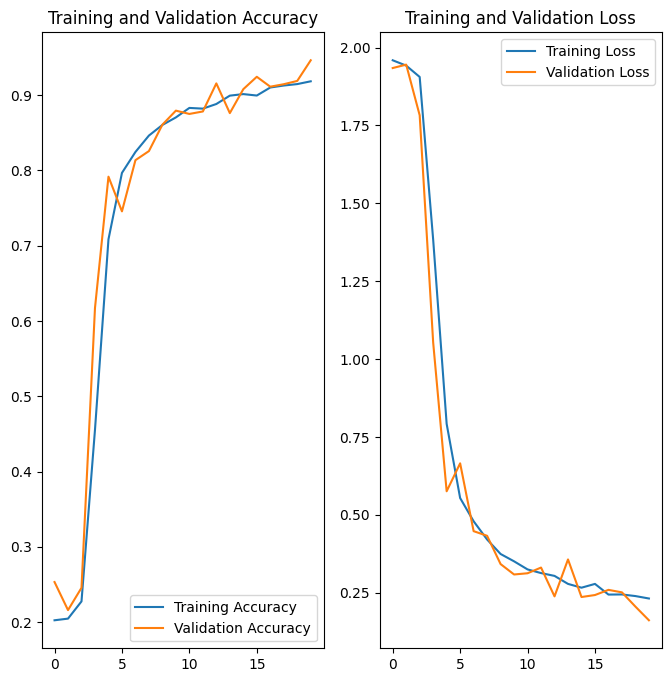

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 35ms/step


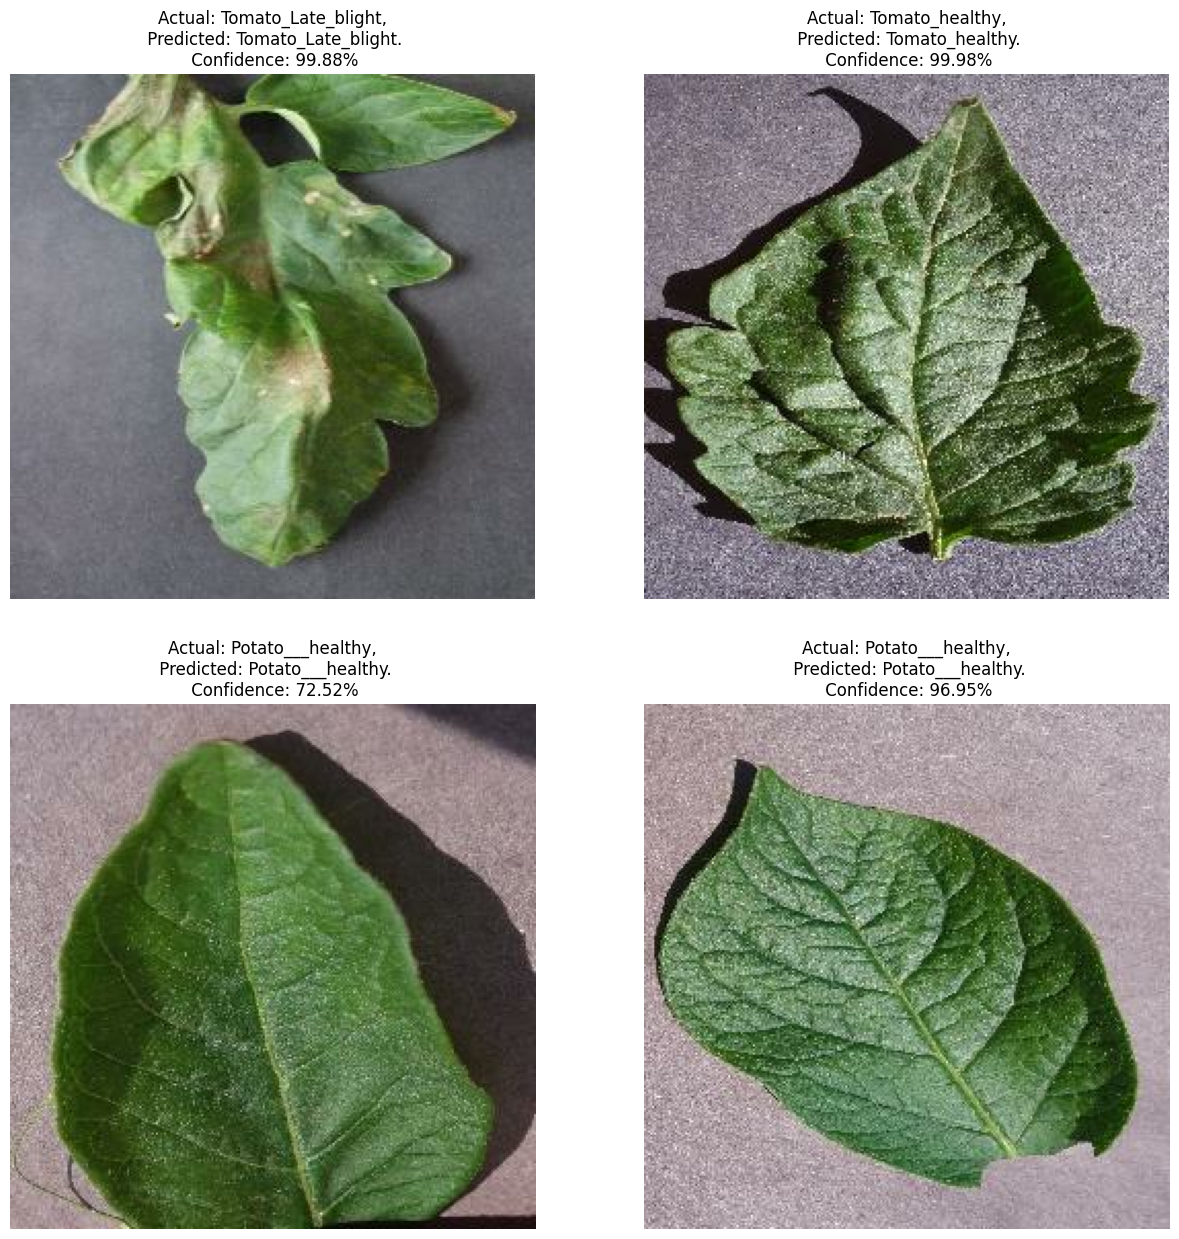

In [24]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_names[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [25]:

from tensorflow.keras.models import load_model

loaded_model = load_model('model.h5')
test_accuracy = loaded_model.evaluate(test_ds)[1]
print('Test accuracy:', test_accuracy)

229/229 [==============================] - 11s 48ms/step - loss: 0.2057 - accuracy: 0.9312
Test accuracy: 0.9312227368354797
